In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, Polygon
from sys import path
from COVIDScenarioPipeline.SEIR import seir, setup, results
import datetime

class WestCoastSpatialSetup():
    """
        Setup for West Coast at the county scale.
    """
    def __init__(self):
        self.setup_name = 'west-coast-AZ-NV'
        self.folder = f'data/{self.setup_name}/'

        self.data = pd.read_csv(f'{self.folder}geodata.csv')
        self.mobility = np.loadtxt(f'{self.folder}mobility.txt')
        self.popnodes = self.data['pop2010'].to_numpy()
        self.nnodes = len(self.data)
        self.counties_shp = gpd.read_file(f'COVIDScenarioPipeline/data/west-coast-AZ-NV/shp/counties_2010_west-coast-AZ-NV.shp')
        self.counties_shp.sort_values('GEOID', inplace=True)
        
        
s = setup.Setup(setup_name = 'mid-west-coast', #'mid-Maryland',
                    spatial_setup = WestCoastSpatialSetup(), #MarylandSpatialSetup(),
                    nsim =  int(1),
                    ti = datetime.date(2020, 1, 31),
                    tf = datetime.date(2020, 10, 1),
                    interactive = False,
                    write_csv = True,
                    dt = 1/4)
filterUSPS = s.spatset.data.stateUSPS.unique()
print(filterUSPS)
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
cases_data = pd.read_csv(url)


counties_shp = gpd.read_file(f'COVIDScenarioPipeline/data/west-coast-AZ-NV/shp/counties_2010_west-coast-AZ-NV.shp')
counties_shp.sort_values('GEOID', inplace=True)

cases_data = cases_data[cases_data['Country/Region'].str.contains('US')]

cases_data = cases_data[cases_data['Province/State'].str.contains('|'.join(filterUSPS))].reset_index(drop=True)

cases_geoid = [0]*len(cases_data)
for idx, row in cases_data.iterrows():
    cases_pos = Point(row['Long'], row['Lat'])
    for key, geom in counties_shp['geometry'].items():
        if (cases_pos.within(geom)):
            cases_geoid[idx] = int(counties_shp['GEOID'][key])

/usr/local/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:15: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


['AZ' 'CA' 'NV' 'OR' 'WA']


In [2]:
cases_data.index = cases_geoid
cases_data = cases_data.T[4:]
cases_data.index = pd.to_datetime(cases_data.index)

In [3]:
cum_cases_data = cases_data.diff()
cum_cases_data[cum_cases_data < 0] = 0

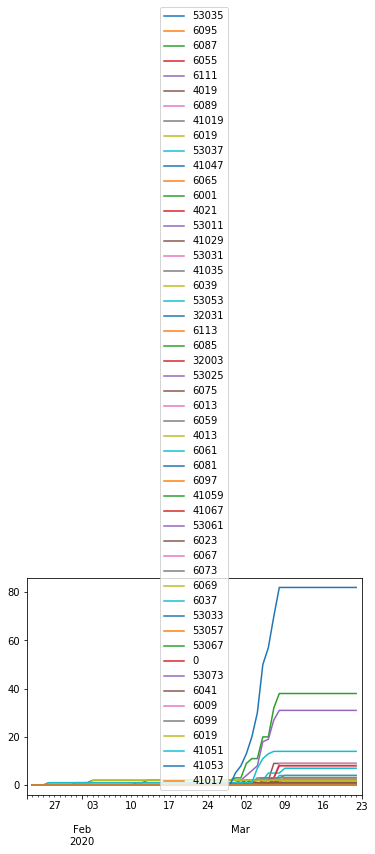

In [4]:
cum_cases_data = cum_cases_data.cumsum()
cum_cases_data.plot()

In [5]:
filter = np.array((s.nnodes, s.t_span))

In [6]:
cum_cases_data = cum_cases_data.resample('D').backfill()

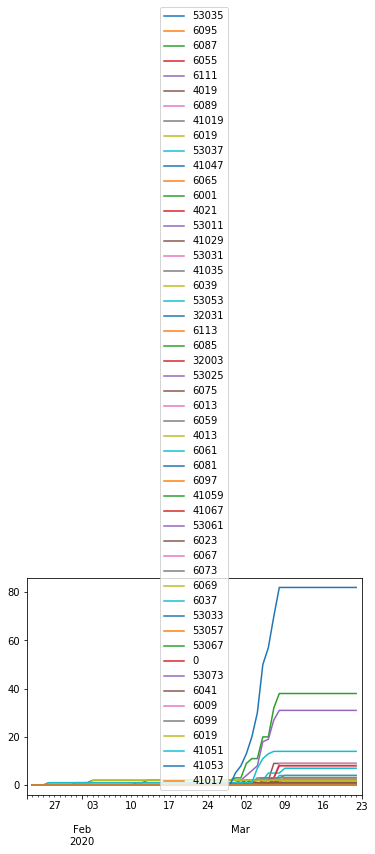

In [7]:
cum_cases_data.plot()
cum_cases_data = cum_cases_data.groupby(cum_cases_data.columns, axis=1).sum()

In [8]:
cum_cases_data.drop(0,axis =1, inplace=True)

In [9]:
cum_cases_all = pd.DataFrame(0, index = pd.date_range(s.ti, s.tf, freq ='D'), columns = np.arange(s.nnodes))
for col in list(cum_cases_data):

    cum_cases_all[s.spatset.data[s.spatset.data['geoid'] == col].id] = cum_cases_data[col]
cum_cases_all.fillna(method='ffill', inplace=True)
cum_cases_all.fillna(value=0, inplace=True)

In [28]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    print(cum_cases_all.loc[datetime.date(2020, 1,31)])

(18262, 18305)

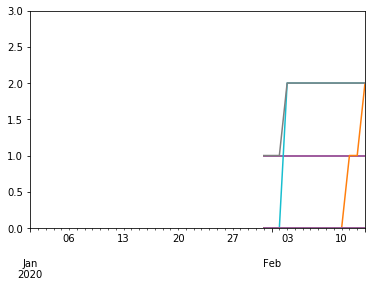

In [10]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(1)
cum_cases_all.plot(legend=False, ax=axes)
axes.set_ylim(0,3)
axes.set_xlim(datetime.date(2020,1,1), datetime.date(2020,2,13))

In [57]:
np.nonzero(cum_cases_all.iloc[-1].to_numpy())

(array([  7,  11,  15,  21,  24,  26,  33,  34,  44,  45,  47,  48,  49,
         51,  52,  55,  57,  59,  63,  71,  74,  87,  99, 104, 107, 113,
        119, 123, 131, 138, 141, 142, 144, 152, 156]),)

In [58]:
a = [cum_cases_all.iloc[-1].to_numpy()[i] for i in np.nonzero(cum_cases_all.iloc[-1].to_numpy())][0]
a

array([ 2.,  2.,  2.,  9.,  1.,  1., 14.,  1.,  4.,  7.,  1.,  2.,  2.,
        3.,  9.,  2., 38.,  1.,  3.,  1.,  2.,  2.,  1.,  2.,  1.,  1.,
        1.,  8.,  1.,  1.,  1., 82.,  1.,  4., 31.])

In [63]:
print([int(s.spatset.data.iloc[int(i)]['geoid']) for i in np.nonzero(cum_cases_all.iloc[-1].to_numpy())[0]])

[4013, 4021, 6001, 6013, 6019, 6023, 6037, 6039, 6059, 6061, 6065, 6067, 6069, 6073, 6075, 6081, 6085, 6089, 6097, 6113, 32003, 32031, 41019, 41029, 41035, 41047, 41059, 41067, 53011, 53025, 53031, 53033, 53037, 53053, 53061]


In [90]:
each stochatic draw of binomial with 5*this number +.1 accross 4 compartement.
remove need.

SyntaxError: invalid syntax (<ipython-input-90-842b8e0a5b1f>, line 1)

In [27]:
cum_cases_all.to_numpy()[31]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [37]:
np.savetxt(f'data/west-coast-AZ-NV/filtergithub.txt', cum_cases_all.to_numpy())

In [38]:
(cum_cases_all.to_numpy())[31]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [11]:
cum_cases_all

,0,1,2,3,4,5,6,7,8,9,...,155,156,157,158,159,160,161,162,163,164
2020-01-01,0,0,0,0,0,0,0,0.0,0,0,...,0,0.0,0,0,0.0,0,0,0.0,0,0
2020-01-02,0,0,0,0,0,0,0,0.0,0,0,...,0,0.0,0,0,0.0,0,0,0.0,0,0
2020-01-03,0,0,0,0,0,0,0,0.0,0,0,...,0,0.0,0,0,0.0,0,0,0.0,0,0
2020-01-04,0,0,0,0,0,0,0,0.0,0,0,...,0,0.0,0,0,0.0,0,0,0.0,0,0
2020-01-05,0,0,0,0,0,0,0,0.0,0,0,...,0,0.0,0,0,0.0,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-27,0,0,0,0,0,0,0,2.0,0,0,...,0,31.0,0,0,0.0,0,0,0.0,0,0
2020-09-28,0,0,0,0,0,0,0,2.0,0,0,...,0,31.0,0,0,0.0,0,0,0.0,0,0
2020-09-29,0,0,0,0,0,0,0,2.0,0,0,...,0,31.0,0,0,0.0,0,0,0.0,0,0
2020-09-30,0,0,0,0,0,0,0,2.0,0,0,...,0,31.0,0,0,0.0,0,0,0.0,0,0
